In [242]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [7]:
def Bfield(r):
    M = 1.2 #in T (also known as remanance)
    V = 10*25*3e-9 #in m3, volume of magnet stack
    m = num*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
    a = 39e-3
    ax = 30e-3
    posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [8]:
num=3

y = np.linspace(-1*inch, 1*inch, 15)
z = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

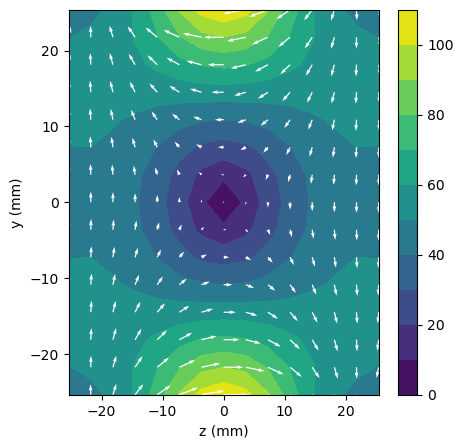

In [9]:
plt.figure(figsize=(5,5))
plot = plt.contourf(z*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],z[0],z[-1]], origin='lower', levels=10)
plt.quiver(z*1e3, y*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [10]:
def line(x, a, b):
    return a*(x)+b

gradient: -35.032502418560604 G/cm


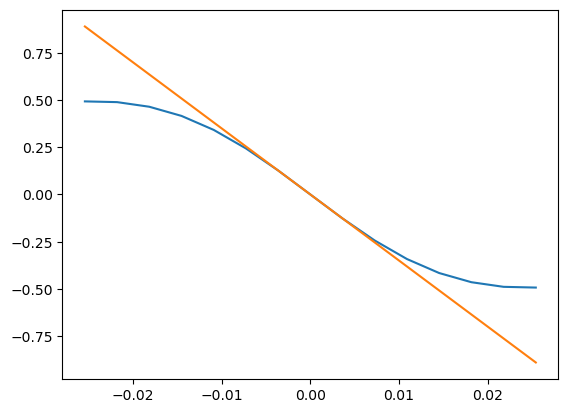

In [11]:
popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(y, By[8,:]*1e4/1e2)
plt.plot(y, line(y, *popt))
print('gradient:', popt[0], 'G/cm')

In [12]:
y = np.linspace(-0.3*inch, 0.3*inch, 15)
x = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in y] for xx in x])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(x))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


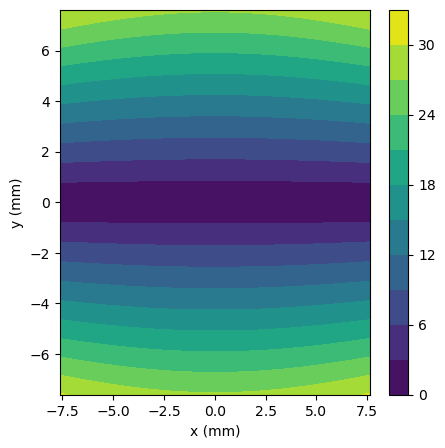

In [13]:
plt.figure(figsize=(5,5))
plot=plt.contourf(x*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],x[0],x[-1]], origin='lower', levels=10)
plt.quiver(x*1e3, y*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [14]:
num_array = np.linspace(1, 6, 10, endpoint=True)
grad_array = []

for num in num_array:
    y = np.linspace(-1*inch, 1*inch, 15)
    z = np.linspace(-1*inch, 1*inch, 15)

    rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

    B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
    Bx = B[:,:][0]
    By = B[:,:][1]
    Bz = B[:,:][2]
    Bmag = np.sqrt(By**2+Bz**2+Bx**2)
    
    popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
    grad_array.append(popt[0])

In [15]:
conv_grad = np.mean(np.divide(grad_array, num_array))

# Monte Carlo

https://arxiv.org/abs/physics/0103085v1

In [218]:
L = 1
S = 0
J = 1
I = 1/2
F = 3/2

gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ
gF

0.6666666666666667

In [18]:
def Zeeman_shift(dmF, r):

    B = np.sqrt(np.sum(np.square(Bfield(r))))
    
    return mB*gF*B*dmF/hbar

In [220]:
def epsilon(k, q):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    
    if q==1:
        return -1/np.sqrt(2)*(z+1j*ihat)
    elif q==0:
        return jhat
    elif q==-1:
        return 1/np.sqrt(2)*(z-1j*ihat)

def rotation_matrix(k, r, pol):
    knorm = k/np.linalg.norm(k)
    B = Bfield(r)
    Bnorm = B/np.linalg.norm(B)
    cos = np.dot(knorm, Bnorm)
    sin = np.sqrt(1-cos**2)
    
    Mq = 1/2* np.array( [[1+cos, -np.sqrt(2)*sin, 1-cos], 
                           [np.sqrt(2)*sin, 2*cos, -np.sqrt(2)*sin], 
                           [1-cos, np.sqrt(2)*sin, 1+cos] ]  )
    
    return np.matmul(Mq,pol)

In [222]:
ki[0]

array([        0.        , -15747331.59694132,  15747331.59694132])

In [229]:
np.sum(np.square(np.abs(rotation_matrix(ki[0], np.array([0, 2, 1]),  epsilon(ki[0], 1)))))

0.9999999999999998

In [230]:
def force2Dmot(r, v):
    '''force from a laser beam i via transition j (delta m == -j)'''
    
    f = 0
    stot = []
    Rtot = []
    
    #saturation for mot beams
    for i in range(4):
        
        si = []
    
        for idx,j in enumerate([1, 0, -1]):

            Wj = np.abs(rotation_matrix(ki[i], r, poli[i])[idx])**2
            
            dist_yz = np.sqrt(np.sum( np.abs(np.cross(r[1:], ki[i][1:]/k))**2))
            Ii = I0*np.exp( -2*r[0]**2/w1**2 -2*dist_yz**2/w2**2 )
            sij = Ii* Wj/Isat        
            
            si.append(sij)
            
        stot.append(si)
    
    #scattering rate for mot beams
    for i in range(4):
        
        si = stot[i]
        Ri = 0
        
        for idx,j in enumerate([1, 0, -1]):
            dmF = -j
            deltaij = Delta - np.dot(ki[i], v) - Zeeman_shift(dmF, r)
            sij = si[idx]
            Rij = Gamma/2 * sij/(1+np.sum(stot)+4*(deltaij/Gamma)**2)
            Ri = Ri+Rij
        
        Rtot.append(Ri)
  
        fi = hbar*ki[i]*Ri
        f = f + fi
        
    #add random scattering force
    for i in range(4):
        kscatt = np.array([0,np.random.uniform(0, 1),np.random.uniform(0, 1)])
        kscatt = kscatt/np.linalg.norm(kscatt)
        fr = hbar*k*kscatt*np.sqrt(Rtot[i]/dt)
        
        f = f# + fr
        
    return f + gravity*m171

In [203]:
def FBeam(r, v, muEff, Bp):
    drm = np.sqrt(np.sum(r**2, axis=0)) + 1e-15
    kdotdr = np.dot(ki, r)
    kdotv = np.dot(ki, v)
    theta = np.arccos(kdotdr/(drm*k))
    Fkir = ((0.5*(1-np.cos(theta)))**2)/(1 + self.Sat(dr) + (2*(Delta-kdotv+self.pol*muEff*Bp*drm/sc.hbar)/self.gamma)**2)
    Fkil = ((0.5*(1+np.cos(theta)))**2)/(1 + self.Sat(dr) + (2*(Delta-kdotv-self.pol*muEff*Bp*drm/sc.hbar)/self.gamma)**2)
    Fkitot = (sc.hbar*self.km*self.gamma*self.Sat(dr)/2)*(Fkir + Fkil)
    Fkixyz = np.outer(self.k/self.km, Fkitot)
    return Fkixyz

In [231]:
def RK4MC(r0, v0, f):
    Natoms=1
    rn, vn = np.zeros((N,3)), np.zeros((N,3))
    rn[0], vn[0] = r0, v0
    for n in range(N-1):
        k1, l1 = dt*f(rn[n], vn[n])/m171,  dt*vn[n]
        k2, l2 = dt*f(rn[n] + l1/2, vn[n] + k1/2)/m171, dt*(vn[n] + k1/2)
        k3, l3 = dt*f(rn[n] + l2/2, vn[n] + k2/2)/m171, dt*(vn[n] + k2/2)
        k4, l4 = dt*f(rn[n] + l3, vn[n] + k3)/m171, dt*(vn[n] + k3)
        rn[n+1] = rn[n] + (1/6)*(l1 + 2*l2 + 2*l3 + l4)
        vn[n+1] = vn[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4) #+ np.array([np.random.normal(0,vd,Natoms),
                                                         #         np.random.normal(0,vd,Natoms),
                                                          #       np.random.normal(0,vd,Natoms)])/np.sqrt(3)
    #cFrac = captureFrac(Natoms,rn)
    #print('capture fraction = {:.3f}'.format(cFrac))
    return rn, vn, f(rn[n], vn[n])

In [232]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

ki = k*np.array( [ -y+z, -y-z, y+z, y-z]) #, -y+z, -y-z wavevectors of the mot beams
poli = np.array( [ epsilon(ki[0], 1), epsilon(ki[1], 1), epsilon(ki[2], 1), epsilon(ki[3], 1)]) #

kslower = -y*k
polslower = x

In [233]:
def test_truncnorm(loc, scale, bounds):
    while True:
        s = np.random.normal(loc, scale)
        if bounds[0] <= s <= bounds[1]:
            break
    return s

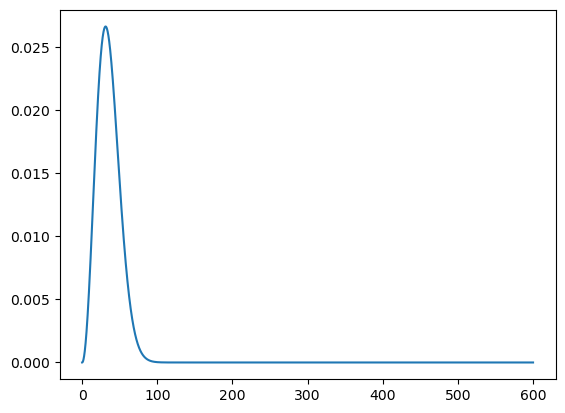

In [245]:
def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

dv = 0.1
v = np.arange(0, 600, dv)

Tl = 10
vlp = np.sqrt(2*kB*Tl/m171)
vlexp = 2/np.sqrt(np.pi)*vlp
vlrms = np.sqrt(3/2)*vlp

y = MB_speed(v,m171,Tl)

plt.plot(v, y)

In [209]:
Tl = 925
def MBsample(Tl):
    i = 0
    dv = 0.1
    v = np.arange(0, 600, dv)
    
    while i<1:
        vi = np.random.choice(v)
        y = MB_speed(vi,m171,Tl)
        eps = np.random.random()
        if eps<y*dv:
            i = i+1
        else:
            i=i
    return vi

In [210]:
6/180*np.pi*260

27.227136331111538

In [239]:
_lambda = 399e-9
k = 2*np.pi/_lambda
Isat = 60e-3*1e4 #W/m2
Gamma = 30e6
w1 = 5e-3
w2 = 5e-3
P = 150e-3
I0 = 2*P/np.pi/w1/w2
m171 = 171*u
Delta = -2*Gamma
dt = 1e-5

#slower:
wslower = 5e-3
Pslower = 150e-3
I0slower = 2*Pslower/np.pi/wslower**2
Deltaslower = -40*Gamma

gravity = g*np.array([0,-1,0])

In [240]:

N=150
dt = 1e-5
Delta= -1.5*Gamma
num = 3
r0 = np.array([0.,-5e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
v_fin = []
p_fin = []

vy0 =  15
v0 = np.array([0, vy0, 0])

r = r0
v = v0
a = gravity

count = 0
tot_count = 150
rn, vn, fn = RK4MC(r, v, force2Dmot)
    
#pos_array = np.real(np.array(pos_array) )
#vel_array = np.real(np.array(vel_array) )
#count_array = np.array(count_array)
#f_array = np.array(f_array)
#B_array = np.array(B_array)

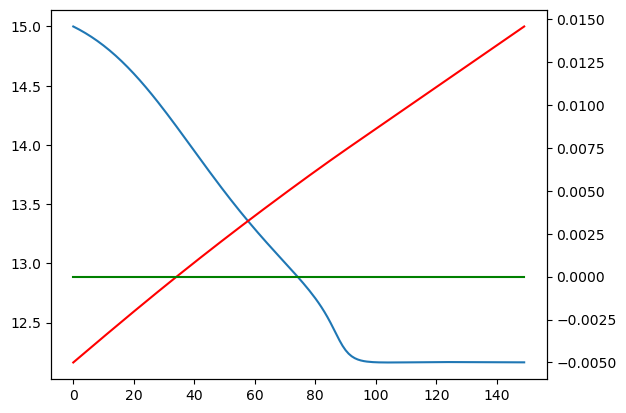

In [241]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.array(vn)[:,1])
ax2.plot(np.array(rn)[:,1], c='r')
ax2.plot(np.array(rn)[:,2], c='g')

In [110]:
dt = 1e-4
Delta_ls = np.linspace(-2.5*Gamma, -0.5*Gamma, 10)
num = 3
r0 = np.array([0.,-5e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
v_fin = []
p_fin = []

for idx in tqdm.tqdm(range(len(Delta_ls))):
    Delta = Delta_ls[idx]
    v_fin_temp = []
    p_fin_temp = []
    vy0_ls =  np.linspace(1, 50, 10)
    for vy0 in vy0_ls:
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0
        a = gravity

        count = 0
        tot_count = 150
        while count<tot_count:
            r, v, f = RK4(r, v, force2Dmot)
            #pos_array.append(r)
            #vel_array.append(v)
            #count_array.append(count)
            #f_array.append(f)
            #B = np.sqrt(np.sum(np.square(Bfield(r))))
            #B_array.append(B)
            count = count+1

        v_fin_temp.append(v)
        p_fin_temp.append(r)
    v_fin.append(v_fin_temp)
    p_fin.append(p_fin_temp)
    
#pos_array = np.real(np.array(pos_array) )
#vel_array = np.real(np.array(vel_array) )
#count_array = np.array(count_array)
#f_array = np.array(f_array)
#B_array = np.array(B_array)

  0%|                                                                                           | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [60]:
plt.imshow(np.array(v_fin)[:,:,1], origin='lower')
plt.colorbar()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

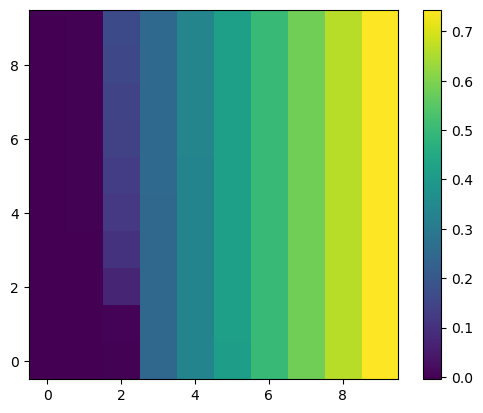

In [32]:
plt.imshow(np.array(p_fin)[:,:,1], origin='lower')
plt.colorbar()

ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 10, 3)

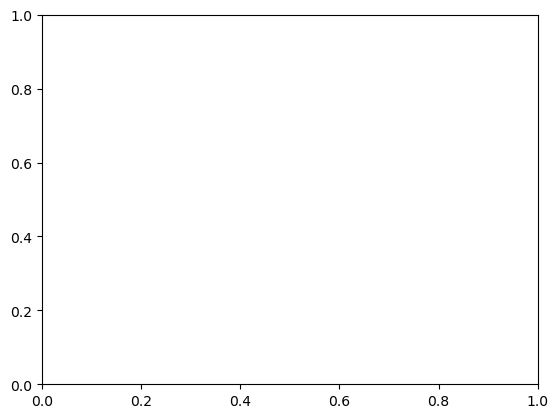

In [37]:
plt.plot(Deltaslower_ls/Gamma, np.array(v_fin))
plt.xlabel('detuning [Gamma]')
plt.ylabel('final velocity m/s')
plt.ylim(40, 90)

In [26]:
dt = 1e-3
Deltaslower_ls = np.linspace(-60*Gamma, -20*Gamma, 10)
num = 4
r0 = np.array([0.,-260e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
trapped_fin = []

for idx in tqdm.tqdm(range(len(Deltaslower_ls))):
    Deltaslower = Deltaslower_ls[idx]
    trapped = 0

    for N in range(1):
        vy0 =  MBsample(Tl)
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0
        a = gravity
        count = 0
        tot_count = 4000
        while count<tot_count:
            r, v, f = RK4(r, v, forceSlower)
            count = count+1
            if abs(r[1])<w2:
                count = tot_count
        if 0<v[1]<50:        
            trapped = trapped+1
            
    trapped_fin.append(trapped)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.12s/it]


(40.0, 90.0)

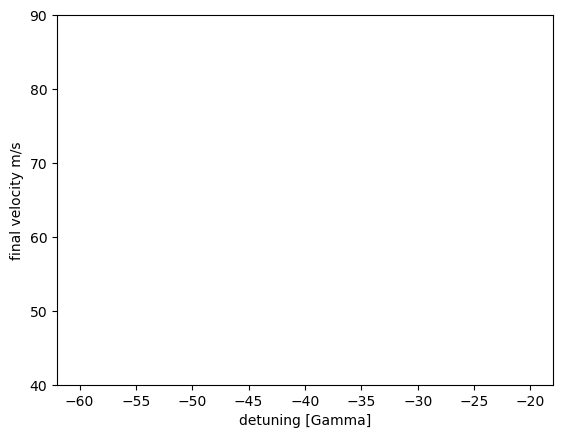

In [28]:
plt.plot(Deltaslower_ls/Gamma, np.array(trapped_fin))
plt.xlabel('detuning [Gamma]')
plt.ylabel('final velocity m/s')
plt.ylim(40, 90)